In [7]:
import numpy as np
import time
import cProfile, pstats
import matplotlib.pyplot as plt

from sys import path as sys_path

import os
from sys import path as sys_path
from dotenv import load_dotenv

load_dotenv()
demreg_path = os.getenv("DEMREG_PATH")
if demreg_path:
    sys_path.append(demreg_path)
else:
    raise RuntimeError("DEMREG_PATH is not set. Please define it in your environment.")

from demmap_pos import demmap_pos
from demmap_numba import demmap_pos_numba

# Benchmark baseline and performance comparison

Here we benchmark the baseline of the DEMMAP_POS function and show improvements.

In [8]:
na = 1000     # Anzahl DEMs (Pixel)
nf = 6        # AIA-Kanäle
nt = 200      # Temperatur-Bins

dd = np.random.random((na, nf)) * 1e3
ed = np.random.random((na, nf)) * 20 + 5
rmatrix = np.random.random((nt, nf)) * 1e-23
logt = np.linspace(5.5, 7.5, nt)
dlogt = np.gradient(logt)
glc = np.ones(nf)
dem_norm0 = np.ones((na, nt))

In [9]:

out_ref = demmap_pos(dd, ed, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0)
out_jit  = demmap_pos_numba(dd, ed, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0)

# Optional: quick sanity check
for a, b, name in zip(out_ref, out_jit, ["dem", "edem", "elogt", "chisq", "dn_reg"]):
    print(name, np.allclose(a, b, rtol=1e-6, atol=1e-8))

100%|██████████| 10.0/10.0 [00:09<00:00, 1.03 x10^2 DEM/s]
100%|██████████| 10.0/10.0 [00:11<00:00, 1.19s/ x10^2 DEM]


dem False
edem False
elogt False
chisq False
dn_reg False


## Baseline Zeitmessung

In [3]:
print(f"Benchmark-Setup: na={na}, nf={nf}, nt={nt}")

start = time.perf_counter()
dem, edem, elogt, chisq, dn_reg = demmap_pos(dd, ed, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0)
end = time.perf_counter()

baseline_time = end - start
print(f"\n✅ Baseline runtime: {baseline_time:.2f} s for {na} DEMs")

Benchmark-Setup: na=1000, nf=6, nt=150


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:21<00:00, 2.17s/ x10^2 DEM]


✅ Baseline runtime: 22.11 s for 1000 DEMs


### Mit Timeit

In [4]:
print("Timeit Messung")
%timeit demmap_pos(dd, ed, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0)

Timeit Messung


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:22<00:00, 2.27s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:23<00:00, 2.30s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:25<00:00, 2.56s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:33<00:00, 3.38s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:33<00:00, 3.37s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:28<00:00, 2.90s/ x10^2 DEM]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:27<00:00, 2.75s/ x10^2 DEM]
100%|████████

29.2 s ± 3.69 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Profilierung mit CProfile

In [5]:
print("\nRunning detailed function profiling...")
with cProfile.Profile() as pr:
    demmap_pos(dd[:200], ed[:200], rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0[:200])
stats = pstats.Stats(pr)
stats.sort_stats('tottime').print_stats(10)


Running detailed function profiling...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:07<00:00, 3.62s/ x10^2 DEM]

         15083 function calls in 7.334 seconds

   Ordered by: internal time
   List reduced from 378 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       82    7.283    0.089    7.283    0.089 {method 'acquire' of '_thread.lock' objects}
        2    0.009    0.004    0.009    0.004 {built-in method _posixsubprocess.fork_exec}
       22    0.006    0.000    0.006    0.000 /Users/gideon/micromamba/envs/hpcp/lib/python3.11/site-packages/zmq/sugar/socket.py:623(send)
        1    0.003    0.003    0.013    0.013 /Users/gideon/micromamba/envs/hpcp/lib/python3.11/site-packages/threadpoolctl.py:1019(_find_libraries_with_dyld)
     2010    0.002    0.000    0.004    0.000 /Users/gideon/micromamba/envs/hpcp/lib/python3.11/site-packages/threadpoolctl.py:1201(_check_prefix)
      402    0.002    0.000    0.010    0.000 /Users/gideon/micromamba/envs/hpcp/lib/python3.11/site-packages/threadpoolctl.py:1143(_make_controller_from_path)
     52

## Numba Optimierung

In [10]:
''' ToDo
try:
    from numba import njit

    @njit
    def dem_inv_gsvd_numba(A, b):
        # Dummy-JIT-Funktion für Beispielzwecke
        return np.linalg.lstsq(A, b, rcond=None)[0]

    # Beispiel: JIT warm-up
    A = np.random.rand(100, 10)
    b = np.random.rand(100)
    dem_inv_gsvd_numba(A, b)

    start = time.perf_counter()
    for _ in range(10):
        dem_inv_gsvd_numba(A, b)
    numba_time = (time.perf_counter() - start) / 10

    print(f"\nNumba test runtime (dummy GSVD): {numba_time:.5f} s")
except ImportError:
    print("Numba not installed – skipping optimization example.")
'''

' ToDo\ntry:\n    from numba import njit\n\n    @njit\n    def dem_inv_gsvd_numba(A, b):\n        # Dummy-JIT-Funktion für Beispielzwecke\n        return np.linalg.lstsq(A, b, rcond=None)[0]\n\n    # Beispiel: JIT warm-up\n    A = np.random.rand(100, 10)\n    b = np.random.rand(100)\n    dem_inv_gsvd_numba(A, b)\n\n    start = time.perf_counter()\n    for _ in range(10):\n        dem_inv_gsvd_numba(A, b)\n    numba_time = (time.perf_counter() - start) / 10\n\n    print(f"\nNumba test runtime (dummy GSVD): {numba_time:.5f} s")\nexcept ImportError:\n    print("Numba not installed – skipping optimization example.")\n'

## Skalierungstests

n=10: 0.23 s
n=100: 2.51 s


100%|██████████| 5.00/5.00 [00:03<00:00, 1.42 x10^2 DEM/s]

n=500: 3.65 s



100%|██████████| 10.0/10.0 [00:04<00:00, 2.02 x10^2 DEM/s]


n=1000: 5.18 s


100%|██████████| 20.0/20.0 [00:10<00:00, 1.95 x10^2 DEM/s]


n=2000: 10.72 s


100%|██████████| 50.0/50.0 [00:24<00:00, 2.06 x10^2 DEM/s]


n=5000: 24.70 s


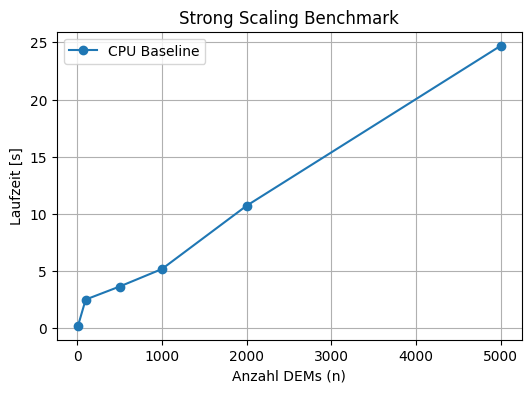

In [13]:
sizes = [10, 100, 500, 1000, 2000, 5000]
times = []

for n in sizes:
    dd_test = np.random.random((n, nf)) * 1e3
    ed_test = np.random.random((n, nf)) * 20 + 5
    dem_norm0_test = np.ones((n, nt))
    
    start = time.perf_counter()
    demmap_pos(dd_test, ed_test, rmatrix, logt, dlogt, glc, dem_norm0=dem_norm0_test)
    end = time.perf_counter()
    
    times.append(end - start)
    print(f"n={n}: {end - start:.2f} s")

plt.figure(figsize=(6,4))
plt.plot(sizes, times, 'o-', label="CPU Baseline")
plt.xlabel("Anzahl DEMs (n)")
plt.ylabel("Laufzeit [s]")
plt.title("Strong Scaling Benchmark")
plt.legend()
plt.grid(True)
plt.show()

## Speed-up-Tabelle (noch Platzhalter)

In [15]:
import pandas as pd
data = {
    "Version": ["Baseline (CPU)", "Optimized (Numba)", "GPU (CuPy)"],
    "Runtime [s]": [baseline_time, np.nan, np.nan],
    "Speed-up": [1.0, np.nan, np.nan]
}
df = pd.DataFrame(data)
display(df)

,Version,Runtime [s],Speed-up
0,Baseline (CPU),4.821416,1.0
1,Optimized (Numba),NaN,NaN
2,GPU (CuPy),NaN,NaN
